In [2]:
import torch
import torch.nn as nn
import sys

sys.path.append("../src")

In [3]:
from deep_eurorack_control.datasets.data_loaders import nsynth_data_loader
from deep_eurorack_control.config import settings

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [4]:
print(settings.DATA_DIR)

None


In [5]:
train_loader, valid_loader = nsynth_data_loader(
    batch_size=8,
    data_dir="/home/sarah/Projects/master_atiam/pam/deep-eurorack-control/data",
    audio_dir="/home/sarah/Projects/master_atiam/pam/nsynth-test/audio",
    nsynth_json="nsynth_string_test.json"
)

audio, pitch = next(iter(valid_loader))
print(audio.shape)
print(pitch)

print(audio[0,:])

ipd.Audio(audio[0,:].numpy(), rate=16000)

torch.Size([8, 65536])
tensor([32, 43, 45, 38, 48, 46, 32, 31])
tensor([0., 0., 0.,  ..., 0., 0., 0.])


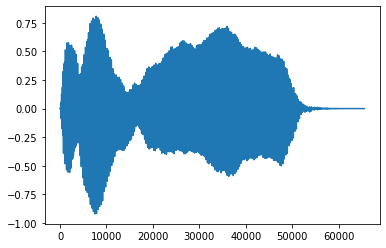

In [5]:
plt.plot(audio[0,:].numpy())

In [6]:
audio.shape
zeros_length = 2**(16) - audio.shape[-1]
print(zeros_length)
res = torch.nn.functional.pad(input=audio, pad=(0, zeros_length), mode='constant', value=0.0)
res.shape

0


torch.Size([8, 65536])

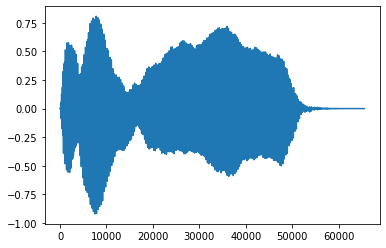

In [7]:
plt.plot(res[0,:].numpy())

In [8]:
ipd.Audio(res[0,:].numpy(), rate=16000)

TEST PQMF

In [9]:
from deep_eurorack_control.models.networks.pqmf_antoine import PQMF

In [10]:
pqmf = PQMF(attenuation=100, n_band=16, polyphase=False)

In [11]:
audio.shape

torch.Size([8, 65536])

In [12]:
x_pqmf = pqmf(audio.reshape(audio.shape[0], 1, -1))

In [13]:
x_pqmf.shape

torch.Size([8, 16, 4096])

In [14]:
ipd.Audio(x_pqmf[0, 7, :].numpy(), rate=16000)

In [15]:
x_pqmf_inv = pqmf.inverse(x_pqmf)
x_pqmf_inv.shape

torch.Size([8, 1, 65536])

In [16]:
x_new = torch.squeeze(x_pqmf_inv)
print(x_new.shape)
ipd.Audio(x_new[0,:].numpy(), rate=16000)

torch.Size([8, 65536])


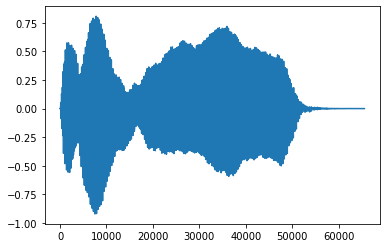

In [17]:
plt.plot(x_new[0,:].numpy())

MODEL evaluation

In [6]:
import os
from deep_eurorack_control.models.rave import RAVE

models_dir = "/home/sarah/Projects/master_atiam/pam/deep-eurorack-control/models"
model_checkpoint = "n_synth_rave__n_band_8__latent_128__sr_16000__noise_True__init_weights_True__b_8__lr_0.0001__e_250__e_warmup_150__vae.pt"

/home/sarah/.pyenv/versions/3.8.8/envs/electroml/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [7]:
model = RAVE(
            n_band=8,
            latent_dim=128,
            hidden_dim=64,
            sampling_rate=16000,
            use_noise=True,
            init_weights=True
        )

In [8]:
checkpoint = torch.load(os.path.join(models_dir, model_checkpoint), map_location=torch.device('cpu'))
print(checkpoint.keys())

dict_keys(['epoch', 'encoder_state_dict', 'decoder_state_dict', 'optimizer_state_dict', 'loss'])


In [9]:
model.encoder.load_state_dict(checkpoint['encoder_state_dict'])
model.decoder.load_state_dict(checkpoint['decoder_state_dict'])
model.encoder.eval()
model.decoder.eval()

Decoder(
  (conv1): Conv1d(128, 1024, kernel_size=(7,), stride=(1,), padding=(3,))
  (up1): UpSamplingLayer(
    (net): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): ConvTranspose1d(1024, 512, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    )
  )
  (res1): ResidualStack(
    (net): Sequential(
      (0): ResnetBlock(
        (block): Sequential(
          (0): LeakyReLU(negative_slope=0.2)
          (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,))
          (2): LeakyReLU(negative_slope=0.2)
          (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,))
        )
        (shortcut): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
      )
      (1): ResnetBlock(
        (block): Sequential(
          (0): LeakyReLU(negative_slope=0.2)
          (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(3,))
          (2): LeakyReLU(negative_slope=0.2)
          (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(4,)

In [71]:
s, p = next(iter(valid_loader))
s = torch.reshape(s, (s.shape[0], 1, -1))
# 1. multi band decomposition pqmf
s = model.multi_band_decomposition(s)

# 2. Encode data
mean, var = model.encoder(s)
print(mean.shape)
print(var.shape)

torch.Size([8, 128, 64])
torch.Size([8, 128, 64])


In [72]:
z, _ = model.reparametrize(mean, var)

In [73]:
z.shape

torch.Size([8, 128, 64])

In [10]:
def latent_space_pca_analysis(model, valid_loader, latent_dim=128):
    z_list = []
    s_list = []
    for s, _ in valid_loader:
        s_list.append(s)
        s = torch.reshape(s, (s.shape[0], 1, -1))

        # 1. multi band decomposition pqmf
        s = model.multi_band_decomposition(s)

        # 2. Encode data
        mean, var = model.encoder(s)

        z, _ = model.reparametrize(mean, var)
        z_list.append(z)
    
    z_valid = torch.cat(z_list, 0)
    z_valid = z_valid.reshape(-1, z_valid.shape[1])
    latent_mean = z_valid.mean(0)
    z_center = z_valid - latent_mean
    
    pca = PCA(latent_dim).fit(z_center.detach().cpu().numpy())
    components = pca.components_
    components = torch.from_numpy(components).to(z_center)

    var = pca.explained_variance_ / np.sum(pca.explained_variance_)
    var = np.cumsum(var)
    
    var_percent = [.8, .9, .95, .99]
    for p in var_percent:
        print(f"{p}%_manifold", np.argmax(var > p))

In [11]:
latent_space_pca_analysis(model, valid_loader)

0.8%_manifold 82
0.9%_manifold 103
0.95%_manifold 115
0.99%_manifold 125


16.609888


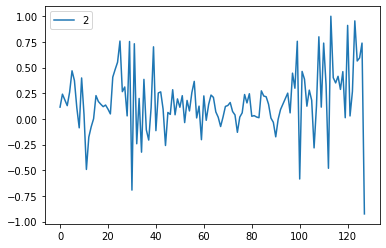

In [34]:
ex_z = z_list[0][0,:,:].detach().cpu().numpy()
z_max = np.max(ex_z)
print(z_max)
for i in range(ex_z.shape[0]):
    if i == 2:
        plt.plot(ex_z[i, :] / z_max, label=f"{i}")
plt.legend()

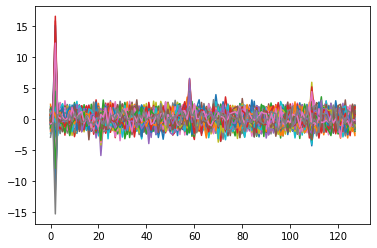

In [35]:
for j in range(ex_z.shape[1]):
    plt.plot(ex_z[:, j])

In [36]:
pca_plot = PCA(2).fit(z_center.detach().cpu().numpy())

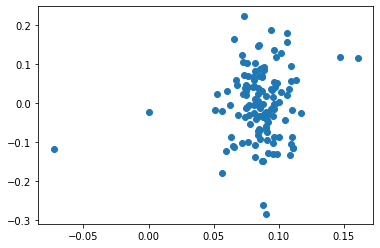

In [37]:
plt.scatter(pca_plot.components_[0, :], pca_plot.components_[1, :])

## Interpolation

In [12]:
def interpolate(model, signal_1, signal_2, n=10):
    s_1 = torch.reshape(signal_1, (signal_1.shape[0], 1, -1))
    # 1. multi band decomposition pqmf
    s_1 = model.multi_band_decomposition(s_1)
    # 2. Encode data
    mean_1, var_1 = model.encoder(s_1)
    z_1, _ = model.reparametrize(mean_1, var_1)
    
    s_2 = torch.reshape(signal_2, (signal_2.shape[0], 1, -1))
    # 1. multi band decomposition pqmf
    s_2 = model.multi_band_decomposition(s_2)
    # 2. Encode data
    mean_2, var_2 = model.encoder(s_2)
    z_2, _ = model.reparametrize(mean_2, var_2)
    
    latent_traj = [z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)]
    res = []
    for i, z in enumerate(latent_traj):
        y = model.decoder(z)
        y = model.multi_band_decomposition.inverse(y)
        res.append(y.reshape(-1).to("cpu").detach().numpy())
    return res

In [13]:
s, p = next(iter(valid_loader))
s_1 = s[0, :].reshape(1, -1)
s_2 = s[1, :].reshape(1, -1)
print(s_1.shape)
print(s_2.shape)

torch.Size([1, 65536])
torch.Size([1, 65536])


In [14]:
res = interpolate(model, s_1, s_2, n=10)

In [16]:
ipd.Audio(s_1.squeeze().detach().numpy(), rate=16000)

In [17]:
ipd.Audio(s_2.squeeze().detach().numpy(), rate=16000)

In [19]:
audio_res = np.concatenate(res)
ipd.Audio(audio_res, rate=16000)

In [20]:
def get_latent_space_valid(model, valid_loader):
    z_list = []
    s_list = []
    for s, _ in valid_loader:
        s_list.append(s)
        s = torch.reshape(s, (s.shape[0], 1, -1))

        # 1. multi band decomposition pqmf
        s = model.multi_band_decomposition(s)

        # 2. Encode data
        mean, var = model.encoder(s)

        z, _ = model.reparametrize(mean, var)
        z_list.append(z)

    z_valid = torch.cat(z_list, 0)
    return z_valid

In [21]:
import random 

def random_gen(model, z_valid, n=10):
    random_idx = random.sample(range(z_valid.shape[0]), n)
    
    res = []
    for i in range(len(random_idx)):
        y = model.decoder(torch.unsqueeze(z_valid[i, :, :], 0))
        y = model.multi_band_decomposition.inverse(y)
        res.append(y.reshape(-1).to("cpu").detach().numpy())
    return res

In [22]:
z_valid = get_latent_space_valid(model, valid_loader)

In [23]:
res_random = random_gen(model, z_valid, n=10)

In [25]:
audio_res_random = np.concatenate(res_random)
ipd.Audio(audio_res_random, rate=16000)